# Reparametrizing the response

In [2]:
from gammaraytoys import ToyTracker2D
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from gammaraytoys.detectors import Simulator, SimpleTraditionalReconstructor
from gammaraytoys.detectors import PointSource, PowerLawSpectrum, MonoenergeticSpectrum


# Detector 
det = ToyTracker2D(material = 'Ge',
                   layer_length = 10*u.m, 
                   layer_positions = np.append(300, np.arange(0,10,1))*u.cm, 
                   layer_thickness = 1*u.cm, 
                   energy_resolution = 0.03,
                   energy_threshold = 20*u.keV)

In [71]:
from histpy import Histogram, Axis

Ei_axis = Axis(np.geomspace(.2,50,26)*u.MeV, label = 'Ei',scale = 'log')
EmFracError_axis = Axis(np.append(np.linspace(-.5,-.1,16)[:-1], np.linspace(-.1,.1,16)), 
                         label = 'EmDeltaFrac')

h_data_delta = Histogram([Ei_axis, EmFracError_axis])

h_nsim = Histogram(Ei_axis)

In [72]:
%%time

ntrig = 4000 #per energy bin

for nEi,Ei in enumerate(h_data_delta.axes['Ei'].centers):

    print(f"{nEi}/{h_data_delta.axes['Ei'].nbins}")

    # Source
    source = PointSource(offaxis_angle = 0*u.deg,
                         spectrum = MonoenergeticSpectrum(energy = Ei))
    
    # Getting Em and the CDS
    reco = SimpleTraditionalReconstructor()
    
    # Sims
    sims = Simulator(detector = det, 
                     sources = source, 
                     reconstructor = reco)
    
    for sim_event, reco_event in sims.run_events(ntrig = ntrig):
    
        h_nsim[nEi] += 1
        
        if reco_event.triggered:
            
            frac_energy_error = ((reco_event.energy - Ei)/Ei).to_value('')
    
            h_data_delta.fill(Ei, frac_energy_error)


0/25
1/25g = 4000/4000 nsim: 61220
2/25g = 4000/4000 nsim: 32734
3/25g = 4000/4000 nsim: 21963
4/25g = 4000/4000 nsim: 16859
5/25g = 4000/4000 nsim: 13126
6/25g = 4000/4000 nsim: 11518
7/25g = 4000/4000 nsim: 9811
8/25g = 4000/4000 nsim: 9124
9/25g = 4000/4000 nsim: 8346
10/25 = 4000/4000 nsim: 7913
11/25 = 4000/4000 nsim: 7607
12/25 = 4000/4000 nsim: 7554
13/25 = 4000/4000 nsim: 7626
14/25 = 4000/4000 nsim: 7972
15/25 = 4000/4000 nsim: 8568
16/25 = 4000/4000 nsim: 9190
17/25 = 4000/4000 nsim: 10402
18/25 = 4000/4000 nsim: 12131
19/25 = 4000/4000 nsim: 14466
20/25 = 4000/4000 nsim: 16835
21/25 = 4000/4000 nsim: 19783
22/25 = 4000/4000 nsim: 24253
23/25 = 4000/4000 nsim: 30719
24/25 = 4000/4000 nsim: 36600
CPU times: user 42min 27s, sys: 1min 54s, total: 44min 21s
Wall time: 45min 16s


(<Axes: xlabel='Ei [MeV]'>, <ErrorbarContainer object of 3 artists>)

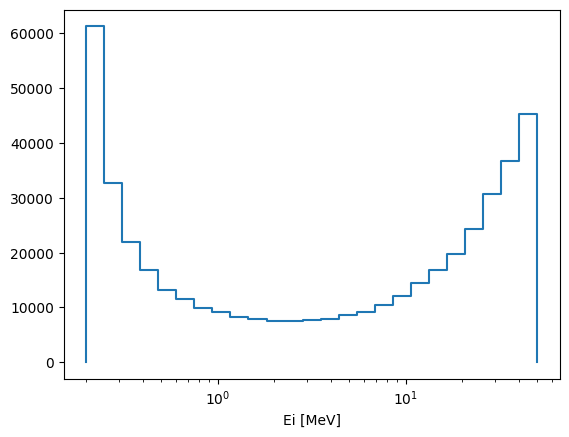

In [73]:
h_nsim.plot()

(<Axes: xlabel='Ei [MeV]'>, <ErrorbarContainer object of 3 artists>)

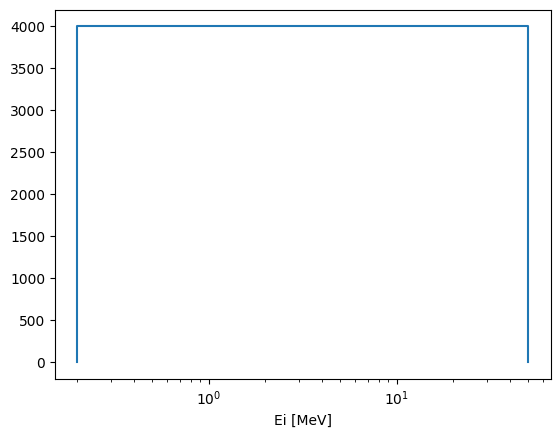

In [74]:
h_ntrig = h_data_delta.project('Ei')
h_ntrig.plot()

(<Axes: xlabel='Ei [MeV]', ylabel='[m]'>,
 <ErrorbarContainer object of 3 artists>)

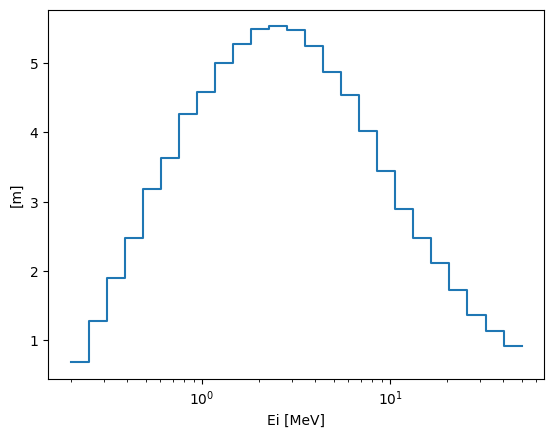

In [113]:
Aeff = (h_ntrig/h_nsim) * det.throwing_plane_size
Aeff.plot()

(<Axes: xlabel='Ei [MeV]', ylabel='EmDeltaFrac'>,
 <matplotlib.collections.QuadMesh at 0x131ad22d0>)

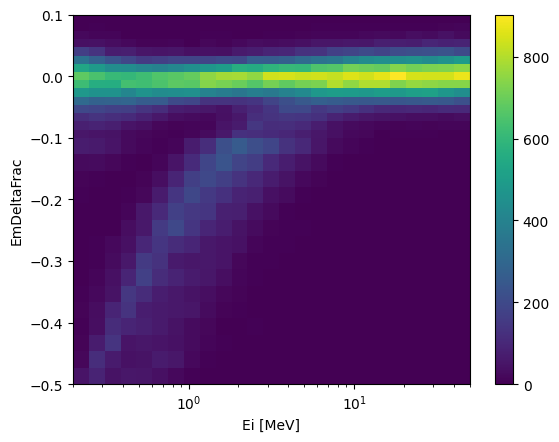

In [76]:
h_data_delta.plot()
#h_data_delta._contents[h_data_delta._contents == 0] = 1

(<Axes: xlabel='Ei [MeV]', ylabel='EmDeltaFrac'>,
 <matplotlib.collections.QuadMesh at 0x131eb2310>)

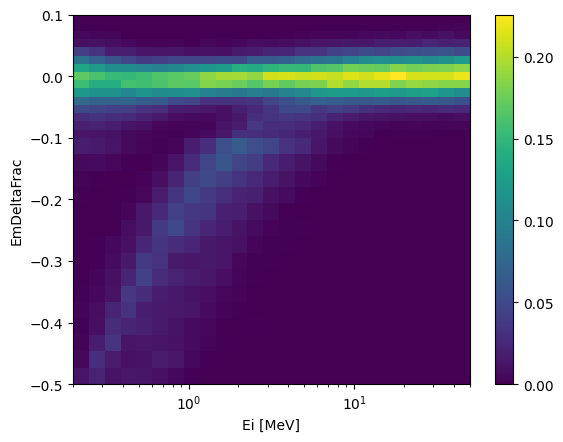

In [77]:
energy_dist = h_data_delta/h_ntrig.contents[:,None]
energy_dist.plot()

AttributeError: module 'matplotlib' has no attribute 'cmap'

/var/folders/3_/k9d8ljjn5hv2xks5822zlyrm26_jpd/T/ipykernel_50283/1055712268.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('viridis')


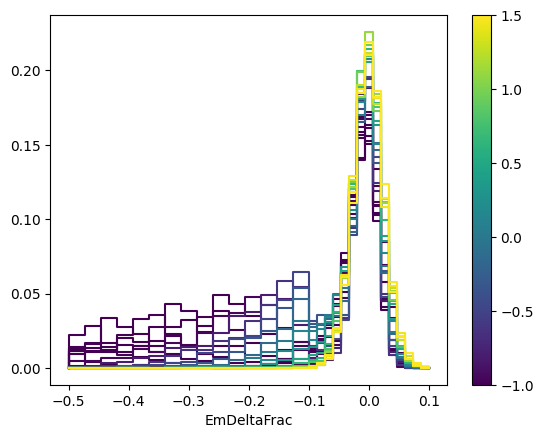

In [123]:
fig,ax = plt.subplots()

cmap = mpl.cm.get_cmap('viridis')

for n,energy in enumerate(energy_dist.axes['Ei'].centers):

    dist = energy_dist.slice[n].project('EmDeltaFrac')

    dist = energy_pdf.slice[n].project('EmDeltaFrac')
    dist *= energy * dist.axis.widths
    
    dist.plot(ax, color = cmap(np.log10(energy.value)/1.5))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-1, vmax=1.5))
fig.colorbar(sm, ax = ax)

(<Axes: xlabel='Ei [MeV]', ylabel='EmDeltaFrac'>,
 <matplotlib.collections.QuadMesh at 0x13209c0d0>)

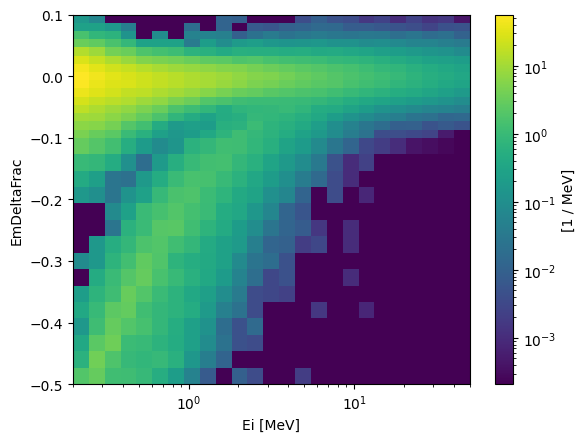

In [121]:
import matplotlib as mpl

phase_space = energy_dist.axes[0].centers[:,None] * energy_dist.axes[1].widths[None,:]

energy_pdf = energy_dist/phase_space
#energy_pdf.plot()
energy_pdf.plot(norm=mpl.colors.LogNorm(clip = True))

In [118]:
Aeff.write("aeff_onaxis_traddet.h5", overwrite = True)
energy_pdf.write("energy_pdf_frac_delta_onaxis_traddet.h5", overwrite = True)

In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from histpy import Histogram, Axis

Aeff = Histogram.open("Aeff_energy_onaxis_traddet.h5")
energy_pdf = Histogram.open("PDF_delta_energy_onaxis_traddet.h5")

In [5]:
# Same file
Aeff.write("response_energy_relative_onaxis_traddet.h5", name = 'Aeff')
energy_pdf.write("response_energy_relative_onaxis_traddet.h5", name = 'PDF')

In [100]:
Ei_axis = Axis(np.geomspace(.2,50,300)*u.MeV, label = 'Ei',scale = 'log')
Em_axis = Axis(np.geomspace(.1,60,301)*u.MeV, label = 'Em',scale = 'log')

Ei_mesh, Em_mesh  = np.broadcast_arrays(Ei_axis.centers[:,None], 
                                        Em_axis.centers[None,:], 
                                        subok = True)

EmDeltaFrac_mesh = ((Em_mesh - Ei_mesh)/Ei_mesh).to_value('')

Rij = Histogram([Ei_axis, Em_axis],
                Em_axis.widths[None,:] * Aeff.interp(Ei_axis.centers)[:,None] * energy_pdf.interp(Ei_mesh, EmDeltaFrac_mesh))

h = Histogram([Ei_axis, Em_axis],
               Em_axis.widths[None,:] * energy_pdf.interp(Ei_mesh, EmDeltaFrac_mesh))


(<Axes: xlabel='Ei [MeV]', ylabel='Em [MeV]'>,
 <matplotlib.collections.QuadMesh at 0x131f54810>)

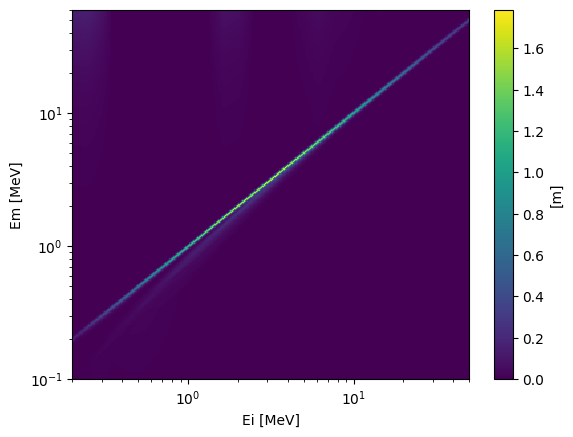

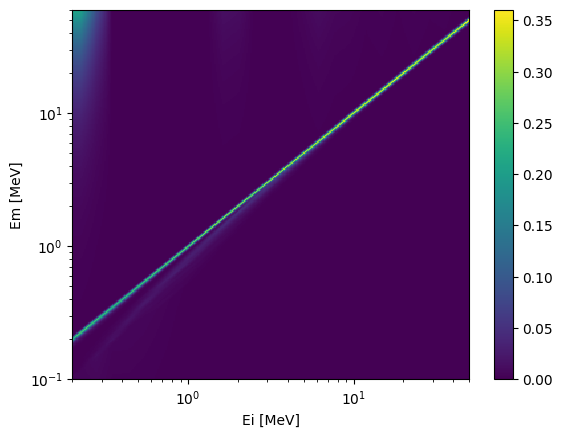

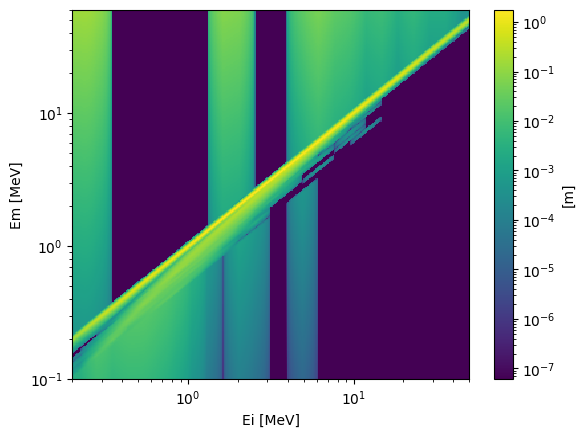

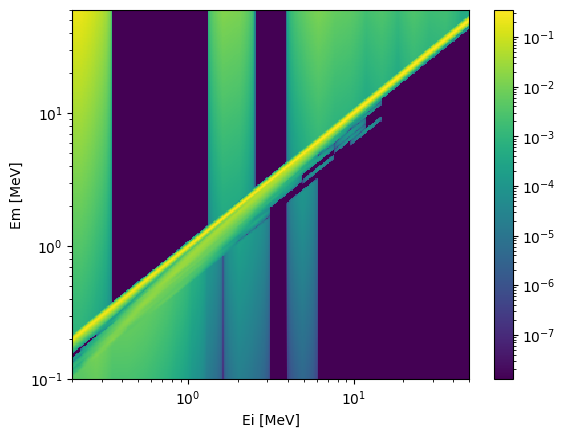

In [101]:
Rij.plot()
h.plot()

Rij.plot(norm=mpl.colors.LogNorm(clip = True))
h.plot(norm=mpl.colors.LogNorm(clip = True))

You can do further optimization. Decouple Aeff (filled quickly) from pdf. Or Change which Ei are sampled. Or maybe re-parametrize the Compton Edge. Seems good enough for the toy model.

## Analysis

In [102]:
flux = 1e-5/u.cm/u.s
line_energy = 2*u.MeV
duration = 10*u.hr

# Source
source = PointSource(offaxis_angle = 0*u.deg,
                     spectrum = MonoenergeticSpectrum(energy = line_energy),
                     flux = flux)

# Getting Em and the CDS
reco = SimpleTraditionalReconstructor()

# Sims
sims = Simulator(detector = det, 
                 sources = source, 
                 reconstructor = reco)

sims.measured_energy_axis = Em_axis

signal = sims.run_binned(duration = duration, axes = 'Em')

In [103]:
tot_expectation = (flux * duration * Aeff.interp(line_energy)).to_value('')
expectation = tot_expectation * Em_axis.widths * energy_pdf.interp(line_energy, 
                                                                   ((Em_axis.centers - line_energy)/line_energy).to_value(''))

expectation = expectation.to_value('')

np.sum(Em_axis.widths * energy_pdf.interp(line_energy, ((Em_axis.centers - line_energy)/line_energy).to_value('')))

tot_expectation

np.float64(197.06580770856678)

(1, 3)

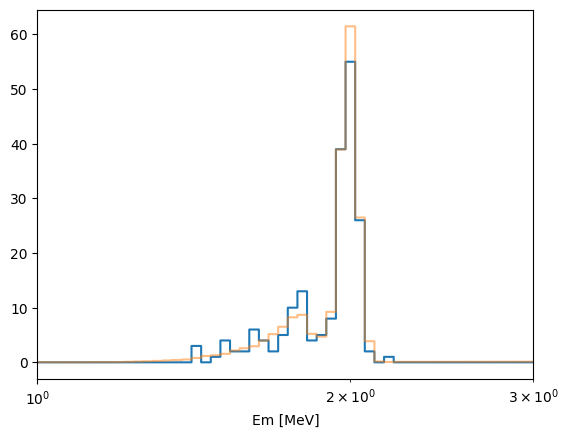

In [104]:
ax,_ = signal.plot()
h_expect = Histogram(Em_axis,expectation)
h_expect.plot(ax, alpha = .5)

ax.set_xlim(1,3)

(<Axes: xlabel='Em [MeV]'>, <ErrorbarContainer object of 3 artists>)

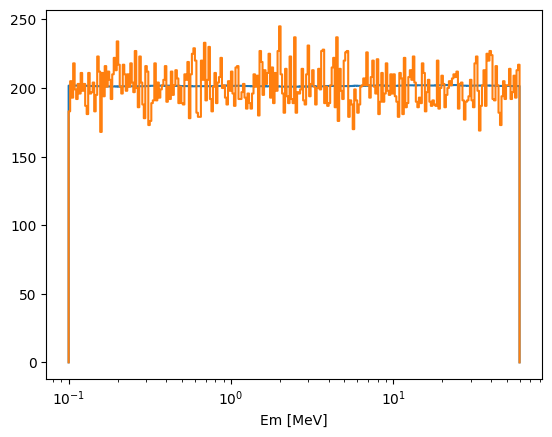

In [105]:
bkg = Histogram(Em_axis)
bkg[:] = np.random.poisson(200, size = bkg.axis.nbins) 

data = bkg + signal

estimated_bkg = Histogram(Em_axis)

masked_bins = 20

for n,energy in enumerate(data.axis.centers):

    left_mask_idx = max(0, n - masked_bins)
    right_mask_idx = min(data.nbins, n + masked_bins)
    
    estimated_bkg[n] = np.mean(np.concatenate([data[:left_mask_idx], data[right_mask_idx:]]))

ax, _ = estimated_bkg.plot()
data.plot(ax)

(<Axes: xlabel='Em [MeV]'>, <ErrorbarContainer object of 3 artists>)

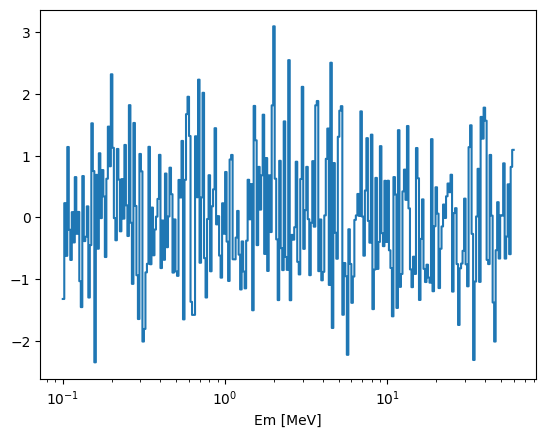

In [106]:
# Do moving window cumsum
rebin = 1
((data.rebin(rebin) - estimated_bkg.rebin(rebin))/np.sqrt(estimated_bkg.rebin(rebin))).plot()

In [108]:
%%time

from gammaraytoys.analysis import poisson_binned_log_likelihood

flux_hyp = 1e-5/u.cm/u.s
Ei_hyp = 2*u.MeV

flux_hyp_axis = Axis(np.geomspace(1e-6, 2e-5, 20)/u.cm/u.s, 
                     label = 'flux',
                     scale = 'log')

Ei_hyp_axis = Axis(np.geomspace(.2, 50, 300)*u.MeV,
                   label = 'energy',
                    scale = 'log')

# Ei_hyp_axis = Axis(np.linspace(1, 3, 20+1)*u.MeV,
#                    label = 'energy',
#                     scale = 'linear')

log_like = Histogram([Ei_hyp_axis, flux_hyp_axis])
log_like0 = Histogram(Ei_hyp_axis)

for nEi, Ei_hyp in enumerate(Ei_hyp_axis.centers):

    print(f"{nEi}/{Ei_hyp_axis.nbins}", end = '\r')
    
    log_like0[nEi] = poisson_binned_log_likelihood(data, estimated_bkg.contents)
    
    for nflux, flux_hyp in enumerate(flux_hyp_axis.centers):

        tot_expectation = (flux_hyp * duration * (Aeff.rebin(4)/4).interp(Ei_hyp))
        
        distribution = Em_axis.widths * energy_pdf.interp(Ei_hyp, 
                       ((Em_axis.centers - Ei_hyp)/Ei_hyp).to_value(''))
        
        distribution /= np.sum(distribution) #Workaround finite widths
        expectation = tot_expectation * distribution

        expectation = expectation.to_value('')

        #print(f"{flux_hyp}  {np.sum(expectation)}/{np.sum(signal)}")
    
        
        log_like[nEi, nflux] = poisson_binned_log_likelihood(data, expectation + estimated_bkg.contents)

CPU times: user 2min 30s, sys: 2.69 s, total: 2min 33s
Wall time: 2min 39s


Penalized from not fitting the right shape! Coherent analysis. ~10-20%

(<Axes: xlabel='energy [MeV]', ylabel='flux [1 / (cm s)]'>,
 <matplotlib.collections.QuadMesh at 0x1340a2790>)

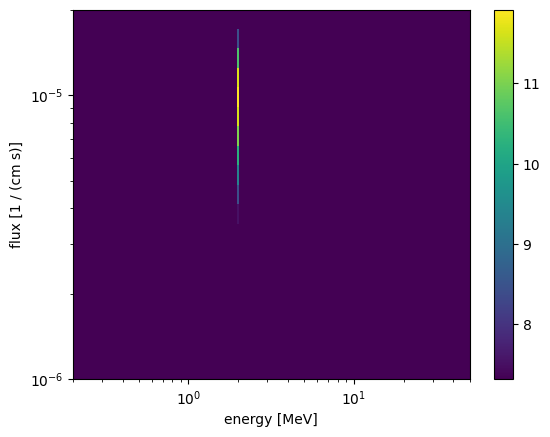

In [109]:
from scipy.stats import chi2

ts = 2*(log_like - log_like0.contents[:,None])

argmax_ts = np.unravel_index(np.argmax(ts), ts.nbins)
max_ts = ts[argmax_ts]

energy_opt = ts.axes[0].centers[argmax_ts[0]] 
flux_opt = ts.axes[1].centers[argmax_ts[1]] 

uncertainty_containment = .9
unc_contour_ts = max_ts - chi2.ppf(uncertainty_containment, df = 2)

fig,ax = plt.subplots()

ts.plot(ax, vmin =  unc_contour_ts)

#ax.set_xlim(1,3)

In [194]:
max_ts


np.float64(17.976967839815188)

(<Axes: xlabel='energy [MeV]'>, <ErrorbarContainer object of 3 artists>)

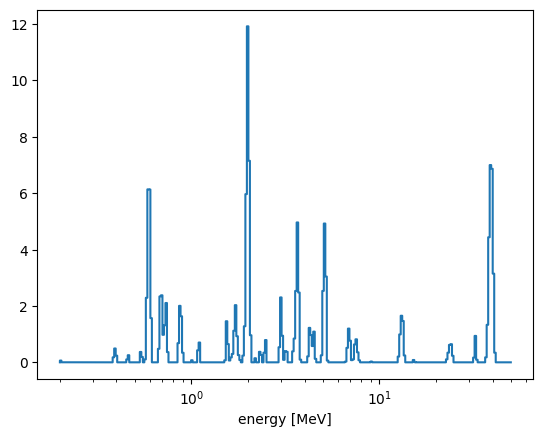

In [110]:
Histogram(ts.axes['energy'], np.maximum(0, np.max(ts, axis = 1))).plot()